Import libraries

In [6]:
import pandas as pd
import glob
import folium
from folium.plugins import MarkerCluster
import numpy as np
import geohashlite
import geopandas as gpd
import json
import geojson
from shapely.geometry import shape
from geopandas import GeoDataFrame
from pylab import *

set path

In [3]:
path = '/home/lefteris/sessions/14/'

list of parquet files

In [3]:
list_files = glob.glob(path + "*.snappy.parquet")

In [4]:
len(list_files)

128

one dataframe from all parquet files

In [5]:
df = pd.DataFrame()
for i in list_files:
    df_list = pd.read_parquet(i)
    df = df.append(df_list[['entityId','latitude','longitude','period']])

In [20]:
# create a copy to keep the original df
dff = df.copy()
len(dff)

4928344

In [21]:
dff.head()

entityId    latitude   longitude  \
0  {'deviceId': '00003D30-5C80-40DD-829A-CA1CF943...   44.326347  -69.775240   
1  {'deviceId': '00006635-7528-4B31-A606-29809527...  -23.844532  151.257760   
2  {'deviceId': '0000A239-3422-489A-B705-BBACAFBF...   56.449203    9.406962   
3  {'deviceId': '00079528-4EA8-47D8-A723-C1199B19...   36.690613  -97.308890   
4  {'deviceId': '000922B6-43CA-4ABD-84A1-789E9783...   12.211107  109.210820   

                                           period  
0  {'start': 1538827222452, 'end': 1538830763241}  
1  {'start': 1538829413776, 'end': 1538829524935}  
2  {'start': 1538828308040, 'end': 1538828964599}  
3  {'start': 1538830071974, 'end': 1538830089574}  
4  {'start': 1538827349422, 'end': 1538827473410}

extract the deviceIds

In [22]:
dff =dff.rename(columns={'entityId':'deviceId'})

In [23]:
dff.head()

deviceId    latitude   longitude  \
0  {'deviceId': '00003D30-5C80-40DD-829A-CA1CF943...   44.326347  -69.775240   
1  {'deviceId': '00006635-7528-4B31-A606-29809527...  -23.844532  151.257760   
2  {'deviceId': '0000A239-3422-489A-B705-BBACAFBF...   56.449203    9.406962   
3  {'deviceId': '00079528-4EA8-47D8-A723-C1199B19...   36.690613  -97.308890   
4  {'deviceId': '000922B6-43CA-4ABD-84A1-789E9783...   12.211107  109.210820   

                                           period  
0  {'start': 1538827222452, 'end': 1538830763241}  
1  {'start': 1538829413776, 'end': 1538829524935}  
2  {'start': 1538828308040, 'end': 1538828964599}  
3  {'start': 1538830071974, 'end': 1538830089574}  
4  {'start': 1538827349422, 'end': 1538827473410}

In [24]:
# get the deviceId from the dict
for index, row in dff.iterrows():
    row['deviceId'] = row['deviceId']['deviceId']

In [25]:
dff.head()

deviceId    latitude   longitude  \
0  00003D30-5C80-40DD-829A-CA1CF943E401   44.326347  -69.775240   
1  00006635-7528-4B31-A606-298095273F39  -23.844532  151.257760   
2  0000A239-3422-489A-B705-BBACAFBF7C50   56.449203    9.406962   
3  00079528-4EA8-47D8-A723-C1199B19EFB5   36.690613  -97.308890   
4  000922B6-43CA-4ABD-84A1-789E9783ECAE   12.211107  109.210820   

                                           period  
0  {'start': 1538827222452, 'end': 1538830763241}  
1  {'start': 1538829413776, 'end': 1538829524935}  
2  {'start': 1538828308040, 'end': 1538828964599}  
3  {'start': 1538830071974, 'end': 1538830089574}  
4  {'start': 1538827349422, 'end': 1538827473410}

extract the minutes

In [26]:
for index, row in dff.iterrows():
    row['period'] = [pd.to_datetime(row['period']['start'], unit='ms').minute,pd.to_datetime(row['period']['end'], unit='ms').minute]

In [27]:
dff.head()

deviceId    latitude   longitude    period
0  00003D30-5C80-40DD-829A-CA1CF943E401   44.326347  -69.775240   [0, 59]
1  00006635-7528-4B31-A606-298095273F39  -23.844532  151.257760  [36, 38]
2  0000A239-3422-489A-B705-BBACAFBF7C50   56.449203    9.406962  [18, 29]
3  00079528-4EA8-47D8-A723-C1199B19EFB5   36.690613  -97.308890  [47, 48]
4  000922B6-43CA-4ABD-84A1-789E9783ECAE   12.211107  109.210820    [2, 4]

In [81]:
# check if the start and end minutes are the same
cnt = 0
for index, row in dff.iterrows():
    if row['period'][0]== row['period'][1]:
        cnt +=1

In [82]:
print(len(dff))
print(cnt)

4928344
4928344


In [ ]:
'''# if they would be the same just add the int as column value
for index, row in dff.iterrows():
    row['period'] = row['period'][0]'''

In [28]:
# save the dataframe to a parquet
dff.to_parquet(path+'dff.parquet')

In [29]:
dff.dtypes

deviceId     object
latitude     object
longitude    object
period       object
dtype: object

In [32]:
dff['latitude'] = dff['latitude'].astype(np.float64)
dff['longitude'] = dff['longitude'].astype(np.float64)

In [33]:
dff.dtypes

deviceId      object
latitude     float64
longitude    float64
period        object
dtype: object

In [34]:
# which deviceId was seen the most
dff.groupby(['deviceId']).size().reset_index(name='counts').sort_values(['counts'], ascending=False)

deviceId  counts
733922   3B72B1DF-71DA-454C-BA6C-F600609ACA7E      50
2291746  B9D5FFAB-F9DF-4813-8F3E-439208E39B60      39
284173   1702B85C-4D71-4056-9513-78BDF1763D8D      39
1315327  6A9D8971-048E-4F16-AA79-7936999C9D0D      37
2303342  BAC660A9-0EBE-47A8-8CBE-19D3D5861B93      37
1280451  67C6BFAD-B5F0-4CD7-BD4C-6BDA9919A96B      37
1539576  7CD15B83-DEBD-45C8-9711-5F7AF73B69B8      36
1194776  60D25E28-2ABC-4D28-83A9-BFA37F1CA13B      36
2011573  A31B9F60-B020-49FD-8E22-DB8247534EA8      35
2086459  A92C746B-B1F9-440F-99F5-A962492C49B3      35
1648089  85A4FD92-7F50-470C-A9DA-609D53D6E9AE      35
3128010  FDB6D199-824C-4156-9F47-45795222079A      35
2531545  CD4F3B9F-A421-4DCA-AA24-3D63B8558081      35
152241   0C59736A-2B90-46C7-9F50-24983D57D2B1      34
685164   3783CDB9-2EEC-4930-8A68-6B5C490F2C8A      34
631798   33341563-60DA-4440-BF28-851113D6CA71      34
89726    07475590-7E6B-46BA-A7BA-7005E3CA48EC      34
423763   2263659C-AE60-4922-946F-82165DAF9297      34
1021006  52B74E56-5F44-4E04-A5B0-1BDEC174A976      34
1970639  9FCF4376-6754-48E1-9213-3D76EE2F99D0      34
709273   3975978C-DF33-4232-97CB-6B3C802EC59B      34
2404447  C2F7EA2C-0FED-4B66-93DA-CB96117C001F      34
979734   4F627C79-381B-4C33-9BA4-09F67DE5D21B      33
347001   1C22110F-A21C-4F2F-9B2F-B8D75B821421      33
2709042  DBB7FD91-7C18-44CE-9BDC-655FE3C2A89F      32
1927677  9C52D82D-49CD-431F-AD00-D6099CD73456      32
2031443  A4B9B2E9-C3C0-4F28-85F2-797D3F290FF1      32
1942270  9D840B89-2269-45AA-80BA-60963153A786      32
3155858  FFF58C58-B45D-423C-A4FC-0BF14F89398B      32
1272085  67197A33-EAAF-401F-A789-845C71DB29DC      32
...                                       ...     ...
1226765  6361F978-3791-4CE1-AB40-F1A5638B084D       1
1226751  6361B999-06FF-4F78-9083-31BF5A457619       1
1226767  6361d054-bfd8-49ed-bcc0-fa18bd89fb65       1
1226768  636204EC-ED39-41DC-AEF4-8BCA38B5C6DA       1
1226770  63621060-ADB9-4039-9A0F-C484F28E0DFA       1
1226771  63621291-833F-4DAE-A33A-7108182C5A49       1
1226772  6362190D-F131-4435-9736-39F2CC4FF6A2       1
1226773  63621A82-EE90-4B25-ACA0-E878098AA270       1
1226774  63621E1E-1DC8-427C-8427-74FF64107B1C       1
1226753  6361BD5F-0C79-40DC-B23F-D9783A9556FB       1
1226750  6361B221-D194-4257-8C5D-229322DDD35F       1
1226727  63612A1F-AB95-4719-A596-980AE6EC87EF       1
1226739  636167F2-A386-45E9-BF42-73112F8A1901       1
1226728  63612B0E-CEDB-4328-9A0B-9F6E169FE0DD       1
1226729  63612FBC-8EE0-4D0E-B85D-D04D99DC480A       1
1226731  6361341D-A841-48F3-B73B-1984A0FFB699       1
1226732  636134B4-6A59-498D-A71B-5FC4B481E266       1
1226734  63614D1C-FADE-4D2F-BE3A-4E07DCCFD15B       1
1226735  63614ECD-AF08-496C-869B-01D09A424015       1
1226736  6361501F-58F5-4241-B879-81C6714E0DF3       1
1226740  63616BB3-525C-4EFA-A744-C85046274BE8       1
1226749  6361AC37-6D2E-4222-98AE-5EEC30BD5DF1       1
1226741  636175AA-C98C-4BB4-B0A3-55B7807760B4       1
1226742  63617757-E11E-4D87-A399-1502E68E755D       1
1226743  636177A5-14B2-4F78-8D5E-EDC1D75407B0       1
1226744  636181DB-2268-4695-8E14-0459BBB5D168       1
1226745  63618264-082B-4105-ADB2-F2652855421F       1
1226746  63618FB1-D537-49FF-BD7D-6458DD4ED7CD       1
1226747  636196FA-6CE3-4B9D-8844-0E81BB5494A8       1
3158109  fffc75f9-4fdc-4e89-ad84-89db8ed21672       1

[3158110 rows x 2 columns]

In [168]:
# groupby filter on one value
len(dff[dff.deviceId == 'B9D5FFAB-F9DF-4813-8F3E-439208E39B60'])

39

In [205]:
# return a dataframe based on deviceId
df_deviceId = dff[dff.deviceId == 'B9D5FFAB-F9DF-4813-8F3E-439208E39B60']
df_deviceId

deviceId   latitude  longitude    period
28346  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798519 -73.256775    [0, 3]
28347  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 20]
28348  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798528 -73.249533  [33, 34]
28349  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798799 -73.247738  [58, 59]
27551  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798591 -73.256547    [3, 7]
27552  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 27]
27927  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798270 -73.256520    [0, 3]
27928  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [19, 20]
27929  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798527 -73.249535  [33, 34]
27930  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798668 -73.248150  [58, 59]
27988  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798590 -73.256546    [4, 7]
27661  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798272 -73.256519    [1, 3]
27662  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [18, 20]
27663  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798528 -73.249533  [33, 34]
27664  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798670 -73.248151  [58, 59]
27871  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798519 -73.256775    [0, 3]
27872  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 20]
27873  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798528 -73.249533  [33, 34]
27874  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798799 -73.247738  [58, 59]
28199  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798600 -73.256800   [4, 17]
27832  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798602 -73.256806    [4, 7]
27833  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798367 -73.256721  [17, 27]
27900  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798500 -73.256798    [0, 3]
27901  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798496 -73.256790  [19, 20]
27902  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798241 -73.249901  [33, 34]
27903  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798798 -73.247742  [58, 59]
27861  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798591 -73.256547    [3, 7]
27862  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 24]
27960  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798603 -73.256805    [4, 7]
27961  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798542 -73.254555  [24, 27]
28136  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798591 -73.256547    [3, 7]
28137  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798363 -73.256660  [17, 27]
27879  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798500 -73.256800   [0, 19]
27880  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798200 -73.249900  [34, 34]
27881  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798800 -73.247700  [59, 59]
27882  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798519 -73.256775    [0, 3]
27883  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798498 -73.256793  [19, 20]
27884  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798242 -73.249900  [33, 34]
27885  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798799 -73.247738  [58, 59]

In [206]:
list_start = []
for index, row in df_deviceId.iterrows():
    list_start.append(row[col_period_index][0])
df_deviceId['start'] = list_start
df_deviceId

/home/lefteris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


deviceId   latitude  longitude    period  \
28346  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798519 -73.256775    [0, 3]   
28347  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 20]   
28348  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798528 -73.249533  [33, 34]   
28349  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798799 -73.247738  [58, 59]   
27551  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798591 -73.256547    [3, 7]   
27552  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 27]   
27927  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798270 -73.256520    [0, 3]   
27928  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [19, 20]   
27929  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798527 -73.249535  [33, 34]   
27930  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798668 -73.248150  [58, 59]   
27988  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798590 -73.256546    [4, 7]   
27661  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798272 -73.256519    [1, 3]   
27662  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [18, 20]   
27663  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798528 -73.249533  [33, 34]   
27664  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798670 -73.248151  [58, 59]   
27871  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798519 -73.256775    [0, 3]   
27872  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 20]   
27873  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798528 -73.249533  [33, 34]   
27874  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798799 -73.247738  [58, 59]   
28199  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798600 -73.256800   [4, 17]   
27832  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798602 -73.256806    [4, 7]   
27833  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798367 -73.256721  [17, 27]   
27900  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798500 -73.256798    [0, 3]   
27901  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798496 -73.256790  [19, 20]   
27902  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798241 -73.249901  [33, 34]   
27903  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798798 -73.247742  [58, 59]   
27861  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798591 -73.256547    [3, 7]   
27862  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 24]   
27960  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798603 -73.256805    [4, 7]   
27961  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798542 -73.254555  [24, 27]   
28136  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798591 -73.256547    [3, 7]   
28137  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798363 -73.256660  [17, 27]   
27879  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798500 -73.256800   [0, 19]   
27880  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798200 -73.249900  [34, 34]   
27881  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798800 -73.247700  [59, 59]   
27882  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798519 -73.256775    [0, 3]   
27883  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798498 -73.256793  [19, 20]   
27884  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798242 -73.249900  [33, 34]   
27885  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798799 -73.247738  [58, 59]   

       start  
28346      0  
28347     17  
28348     33  
28349     58  
27551      3  
27552     17  
27927      0  
27928     19  
27929     33  
27930     58  
27988      4  
27661      1  
27662     18  
27663     33  
27664     58  
27871      0  
27872     17  
27873     33  
27874     58  
28199      4  
27832      4  
27833     17  
27900      0  
27901     19  
27902     33  
27903     58  
27861      3  
27862     17  
27960      4  
27961     24  
28136      3  
28137     17  
27879      0  
27880     34  
27881     59  
27882      0  
27883     19  
27884     33  
27885     58

In [207]:
# take out similar points

# drop duplicates
df_deviceId_nodup = df_deviceId.drop_duplicates(subset=['latitude','longitude', 'start'], keep='first')
# show the remaining df
df_deviceId_nodup.sort_values(['start'])

deviceId   latitude  longitude    period  \
28346  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798519 -73.256775    [0, 3]   
27879  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798500 -73.256800   [0, 19]   
27900  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798500 -73.256798    [0, 3]   
27927  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798270 -73.256520    [0, 3]   
27661  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798272 -73.256519    [1, 3]   
27551  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798591 -73.256547    [3, 7]   
27960  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798603 -73.256805    [4, 7]   
27832  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798602 -73.256806    [4, 7]   
27988  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798590 -73.256546    [4, 7]   
28199  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798600 -73.256800   [4, 17]   
28347  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [17, 20]   
27833  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798367 -73.256721  [17, 27]   
28137  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798363 -73.256660  [17, 27]   
27662  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [18, 20]   
27883  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798498 -73.256793  [19, 20]   
27928  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798700 -73.256615  [19, 20]   
27901  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798496 -73.256790  [19, 20]   
27961  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798542 -73.254555  [24, 27]   
27929  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798527 -73.249535  [33, 34]   
28348  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798528 -73.249533  [33, 34]   
27902  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798241 -73.249901  [33, 34]   
27884  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798242 -73.249900  [33, 34]   
27880  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798200 -73.249900  [34, 34]   
27930  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798668 -73.248150  [58, 59]   
28349  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798799 -73.247738  [58, 59]   
27664  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798670 -73.248151  [58, 59]   
27903  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798798 -73.247742  [58, 59]   
27881  B9D5FFAB-F9DF-4813-8F3E-439208E39B60  40.798800 -73.247700  [59, 59]   

       start  
28346      0  
27879      0  
27900      0  
27927      0  
27661      1  
27551      3  
27960      4  
27832      4  
27988      4  
28199      4  
28347     17  
27833     17  
28137     17  
27662     18  
27883     19  
27928     19  
27901     19  
27961     24  
27929     33  
28348     33  
27902     33  
27884     33  
27880     34  
27930     58  
28349     58  
27664     58  
27903     58  
27881     59

interactive map of trajectory

In [208]:
# just the deviceId 3B72B1DF-71DA-454C-BA6C-F600609ACA7E
locations = df_deviceId_nodup[['latitude', 'longitude']]
locationlist = locations.values.tolist()

In [253]:
map = folium.Map(location=[40.798141, -73.252445], zoom_start=16.5)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point],popup=str(df_deviceId_nodup['start'].iloc[point]),icon=folium.Icon(color='green')).add_to(map)
map

read parquet

In [4]:
# in case kernel died
dff = pd.read_parquet(path+'dff.parquet')
# convert column types to numeric
dff['latitude'] = dff['latitude'].astype(np.float64)
dff['longitude'] = dff['longitude'].astype(np.float64)
#dff['start'] = dff['period'].astype(np.int64)

In [5]:
dff.head()

deviceId   latitude   longitude    period
0  00003D30-5C80-40DD-829A-CA1CF943E401  44.326347  -69.775240   [0, 59]
1  00006635-7528-4B31-A606-298095273F39 -23.844532  151.257760  [36, 38]
2  0000A239-3422-489A-B705-BBACAFBF7C50  56.449203    9.406962  [18, 29]
3  00079528-4EA8-47D8-A723-C1199B19EFB5  36.690613  -97.308890  [47, 48]
4  000922B6-43CA-4ABD-84A1-789E9783ECAE  12.211107  109.210820    [2, 4]

In [213]:
full_locations = dff[['latitude', 'longitude']]
full_locationlist = full_locations.values.tolist()[:1050] # just 1050 points

In [214]:
map2 = folium.Map(location=[42.845683, -36.630022], tiles='CartoDB dark_matter', zoom_start=1.5)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(full_locationlist)):
    folium.Marker(full_locationlist[point], popup='2018-10-06 00:'+str(dff['period'].iloc[point])).add_to(marker_cluster)
map2

density geohash

In [218]:
# copy the df
dff1 = dff.copy()

In [223]:
# iterate over df and find the geohashes
list_geohash = []
for index, row in dff1.iterrows():
    list_geohash.append(geohashlite.encode(row['latitude'], row['longitude'], 2))
dff1['geohash'] = list_geohash

In [224]:
dff1.head()

deviceId   latitude   longitude    period  \
0  00003D30-5C80-40DD-829A-CA1CF943E401  44.326347  -69.775240   [0, 59]   
1  00006635-7528-4B31-A606-298095273F39 -23.844532  151.257760  [36, 38]   
2  0000A239-3422-489A-B705-BBACAFBF7C50  56.449203    9.406962  [18, 29]   
3  00079528-4EA8-47D8-A723-C1199B19EFB5  36.690613  -97.308890  [47, 48]   
4  000922B6-43CA-4ABD-84A1-789E9783ECAE  12.211107  109.210820    [2, 4]   

  geohash  
0      dr  
1      r7  
2      u4  
3      9y  
4      w6

In [225]:
# save the dataframe to a parquet
dff1.to_parquet(path+'dff_geohash.parquet')

In [232]:
# create a density df grouping by geohash
dff1_geohash_density = dff1.groupby(['geohash']).size().reset_index(name='counts').sort_values(['counts'],ascending=False)

In [238]:
dff1_geohash_density.head()

geohash  counts
127      dp  539652
129      dr  521648
126      dn  346115
70       9v  260614
123      dj  228572

In [237]:
def geohash_to_geometry(geohash):
    converter = geohashlite.GeoJsonHasher()
    converter.geohash_codes = [geohash]
    converter.decode_geohash(multipolygon=True)
    geo = shape(geojson.loads(json.dumps(converter.geojson['features'][0]['geometry'])))
    return geo

In [239]:
# iterate over df and find the geometry geohashes
list_geogeohash = []
for index, row in dff1_geohash_density.iterrows():
    list_geogeohash.append(geohash_to_geometry(row['geohash']))
dff1_geohash_density['geometry'] = list_geogeohash

In [241]:
dff1_geohash_density.head()

geohash  counts                                           geometry
127      dp  539652  POLYGON ((-90 39.375, -78.75 39.375, -78.75 45...
129      dr  521648  POLYGON ((-78.75 39.375, -67.5 39.375, -67.5 4...
126      dn  346115  POLYGON ((-90 33.75, -78.75 33.75, -78.75 39.3...
70       9v  260614  POLYGON ((-101.25 28.125, -90 28.125, -90 33.7...
123      dj  228572  POLYGON ((-90 28.125, -78.75 28.125, -78.75 33...

In [245]:
gdf1_geohash_density = gpd.GeoDataFrame(dff1_geohash_density, crs={'init': 'epsg:4326'}, geometry='geometry')

In [575]:
def fillcolor_obj11(number_of_threshold, counts):
    # find the count distribution thresholds
    # counts is the column name
    all_counts = (gdf1_geohash_density.counts.values.tolist())
    threshold_list = np.linspace(min(all_counts), max(all_counts), num=number_of_threshold,dtype=int).tolist()
    
    cmap = cm.get_cmap('RdPu', number_of_threshold-1)
    list_rgb_codes = []
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        list_rgb_codes.append(matplotlib.colors.rgb2hex(rgb))
    
    for i in range(0,len(threshold_list)-1):
        if counts in range(threshold_list[i], threshold_list[i+1]):
            return list_rgb_codes[i]

In [576]:
def fillcolor_obj10(counts):
    if 0<counts and counts<134913:
        return '#fff5eb'
    elif 134914<counts and counts<269826:
        return '#fdb97d'
    elif 269827<counts and counts<404739:
        return '#e95e0d'
    else:
        return '#7f2704'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a3776a5c0>]],
      dtype=object)

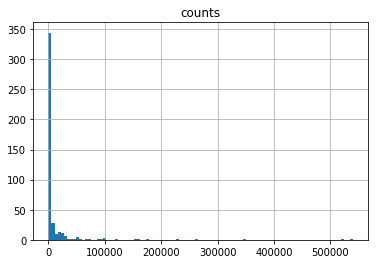

In [419]:
gdf1_geohash_density.hist('counts',bins=100)

In [572]:
def stylefunc(feature):
    obj={'weight':1}
    props = feature['properties']
    counts=float(props['counts'])
    obj['fillColor']= fillcolor_obj11(20,counts)
    obj['color']='black'
    obj['fillOpacity']=0.9
    #obj['radius']=(np.log2(props['population'])**4)/3
    return obj

In [573]:
mapa = folium.Map([42.845683, -36.630022], zoom_start=2, tiles='Stamen Toner')

'''
# convert the gdf into gson
geoPath = gdf1_geohash_density.geometry.to_json()
data1 = gdf1_geohash_density.counts.to_json()

# use the choropleth from folium
mapa.choropleth(geo_data=geoPath, data=gdf1_geohash_density, 
    columns=['geohash', 'counts'], 
    key_on='feature.id',
    fill_color='Spectral', 
    fill_opacity=0.7, line_opacity=0.2,
    legend_name='count density',
    threshold_scale=[1,185713,278569,371425,464281,539652])
mapa
'''

# https://nbviewer.jupyter.org/github/jtbaker/folium/blob/geojsonmarker/examples/GeoJsonMarkersandTooltips.ipynb
folium.GeoJson(data=gdf1_geohash_density,
               name='Geohashes',smooth_factor=2,
               style_function=stylefunc,
               #style_function=lambda x: {'color':'green','fillColor':'0.7','weight':2},
                tooltip=folium.GeoJsonTooltip(fields=['geohash','counts'],
                                              labels=False,
                                              sticky=False),
               highlight_function=lambda x: {'weight':4,'color':'red','fillColor':'red'}
              ).add_to(mapa)

folium.LayerControl().add_to(mapa)

from folium.plugins import MeasureControl
mapa.add_child(MeasureControl())

mapa

In [ ]:
# investigate the normalization of count numbers cause it looks that there is MAUP

Appendix

In [574]:
# find the color threshold
a = (gdf1_geohash_density.counts.values.tolist())
np.linspace(min(a), max(a), num=5, dtype=int).tolist()

[1, 134913, 269826, 404739, 539652]

In [ ]:
# getting colormap codes
cmap = cm.get_cmap('Oranges', 4)
list_rgb_codes = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    list_rgb_codes.append(matplotlib.colors.rgb2hex(rgb))
list_rgb_codes

In [35]:
# groupby based on minutes

#dff.groupby(['period']).groups # returns a dic
#dff.groupby(['period']).agg('count') #returns a df with all columns
#dff.groupby(['period']).size().reset_index(name='counts') #returns a df with count column

In [20]:
file1.head()

dateId  hourId                                           entityId  \
0  20181006      12  {'deviceId': '0001266D-FF9D-4D8E-8541-849480D7...   
1  20181006      12  {'deviceId': '00019323-B746-4070-B415-929D9BA7...   
2  20181006      12  {'deviceId': '0002D813-D837-4DE9-A081-124C61A3...   
3  20181006      12  {'deviceId': '0005F273-2FD3-4E75-8487-C80FF1DA...   
4  20181006      12  {'deviceId': '000A3918-FC4F-4481-8E4D-A5052786...   

     latitude   longitude   radius  \
0   28.605906  -81.488724  0.00000   
1   -8.071678  -34.896477  0.00000   
2   42.560860  -90.640610  0.01354   
3   40.790400  -74.024600  0.00000   
4  -27.611801  152.768190  0.00000   

                                           period  
0  {'start': 1538829565068, 'end': 1538830722364}  
1  {'start': 1538827225703, 'end': 1538829577630}  
2  {'start': 1538828016067, 'end': 1538828338427}  
3  {'start': 1538829114773, 'end': 1538830333120}  
4  {'start': 1538827367392, 'end': 1538827899849}

In [22]:
file2.head()

dateId  hourId                                           entityId  \
0  20181006      12  {'deviceId': '00018864-E82C-4286-B241-78028C49...   
1  20181006      12  {'deviceId': '00018864-E82C-4286-B241-78028C49...   
2  20181006      12  {'deviceId': '00058857-E035-4A37-BA01-9B273D31...   
3  20181006      12  {'deviceId': '00065ADA-08F9-4DAB-81D3-990F4166...   
4  20181006      12  {'deviceId': '0007EA57-A66F-48DD-BDD3-0A7A0628...   

    latitude   longitude    radius  \
0  26.296974  -81.808100  0.000000   
1  26.297001  -81.808098  0.000000   
2  36.657640   43.605324  0.000952   
3  12.003506  120.193590  0.010335   
4  45.668064  -91.804430  0.002030   

                                           period  
0  {'start': 1538827609838, 'end': 1538827919600}  
1  {'start': 1538827345867, 'end': 1538827891496}  
2  {'start': 1538827784327, 'end': 1538829681590}  
3  {'start': 1538830207907, 'end': 1538830400073}  
4  {'start': 1538830359372, 'end': 1538830792821}

In [25]:
file2.dtypes

dateId         int32
hourId         int32
entityId      object
latitude      object
longitude     object
radius       float64
period        object
dtype: object

In [68]:
file2.entityId.loc[1]

{'deviceId': '00018864-E82C-4286-B241-78028C491773',
 'sspId': 78,
 'appBundle': '418987775'}

In [67]:
file2.entityId.loc[0]['deviceId']

'00018864-E82C-4286-B241-78028C491773'

In [61]:
file2.groupby(['dateId']).groups

{20181006: Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             38548, 38549, 38550, 38551, 38552, 38553, 38554, 38555, 38556,
             38557],
            dtype='int64', length=38558)}

In [72]:
file2[file2['entityId']'deviceId'=='00018864-E82C-4286-B241-78028C491773']

KeyError: ('entityId', 'deviceId')